In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip install scikit-plot --quiet
!pip install jellyfish --quiet
#!pip freeze --quiet
#!pip install scikit-optimize --quiet
#!pip install python-Levenshtein --quiet


In [27]:
import pandas as pd
import numpy as np
import os
import sys
import inspect

# DateTime
import datetime
from datetime import date, timedelta, datetime

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scikitplot as skplt
from pandas.plotting import scatter_matrix

# Preprocessing
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Kmeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Hierarchical Clustering
import nltk
from nltk.corpus import stopwords
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Re-Utilise the model
from joblib import dump, load



In [28]:
Customer_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kpmg/Raws/processed/Customer_df_merged.csv')
Transactions_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kpmg/Raws/processed/Transactions_df.csv')
raw_df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/kpmg/Raws/KPMG_VI_New_raw_data_update_final.xlsx',  sheet_name=['NewCustomerList'])

<ipython-input-28-0d9e6babf9d1>:3: FutureWarning:

Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])



# 1.0 Data Preprocesssing



###1.1 Feature Engineering/ Encoding



In [29]:
#merge
Transactions_df_merged = pd.merge(Transactions_df, Customer_df, on='customer_id', how='left')
cols = ['transaction_id','customer_id', 'gender','DOB',
       'transaction_date',
       'online_order', 'order_status',
       'brand', 'product_line','product_class', 'product_size',
       'list_price', 'standard_cost',
       'product_first_sold_date',
       'past_3_years_bike_related_purchases', 'job_title',
       'job_industry_category', 'wealth_segment', 'deceased_indicator',
       'owns_car', 'tenure', 'state',
       'property_valuation']
Transactions_df_merged = Transactions_df_merged[cols]
Transactions_df_merged.dropna( inplace=True)
Transactions_df_merged.reset_index(inplace=True)
print(Transactions_df_merged.info())
print('*'*50)

#feature engineer
Transactions_df_merged['age'] = (pd.to_datetime('now') - pd.to_datetime(Transactions_df_merged['DOB'], format='%Y-%m-%d')).astype('<m8[Y]')
Transactions_df_merged['profit'] = Transactions_df_merged['list_price']-Transactions_df_merged['standard_cost']
Transactions_df_merged['transaction_date'] = pd.to_datetime(Transactions_df_merged['transaction_date'], format='%Y-%m-%d')
Transactions_df_merged['year'] = Transactions_df_merged['transaction_date'].dt.year
Transactions_df_merged['month'] = Transactions_df_merged['transaction_date'].dt.month
Transactions_df_merged['dayOfWeek'] = Transactions_df_merged['transaction_date'].dt.weekday
Transactions_df_merged['product_first_sold_date'] = pd.to_datetime(Transactions_df_merged['product_first_sold_date'])
Transactions_df_merged['product_first_sold_tilnow'] = (datetime.now() - Transactions_df_merged['product_first_sold_date']).dt.days//365
Transactions_df_merged = Transactions_df_merged.drop(['DOB','list_price','standard_cost','product_first_sold_date'], axis=1)

#feature encoding
order_status_dict = { 'Cancelled': 0,'Approved': 1}
product_class_dict = {'low': 0, 'medium': 1, 'high': 2}
product_size_dict = {'small': 0,'medium': 1, 'large': 2}
Transactions_df_merged['order_status'] = Transactions_df_merged['order_status'].map(order_status_dict)
Transactions_df_merged['product_class'] = Transactions_df_merged['product_class'].map(product_class_dict)
Transactions_df_merged['product_size'] = Transactions_df_merged['product_size'].map(product_size_dict)
print(order_status_dict)
print(product_class_dict)
print(product_size_dict)
print('*'*50)

cols = ['transaction_id','customer_id',
        'age','gender', 'wealth_segment','state', 'job_title','job_industry_category', 'owns_car', 'past_3_years_bike_related_purchases',
        'tenure', 'property_valuation',
        'transaction_date', 'month', 'dayOfWeek',
        'brand', 'product_line', 'product_class','product_size',
        'online_order', 'product_first_sold_tilnow','profit'
       ]
Transactions_df_merged = Transactions_df_merged[cols]
print(Transactions_df_merged.info())
pd.set_option('display.max_columns', None)
Transactions_df_merged

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13628 entries, 0 to 13627
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   index                                13628 non-null  int64  
 1   transaction_id                       13628 non-null  int64  
 2   customer_id                          13628 non-null  int64  
 3   gender                               13628 non-null  object 
 4   DOB                                  13628 non-null  object 
 5   transaction_date                     13628 non-null  object 
 6   online_order                         13628 non-null  bool   
 7   order_status                         13628 non-null  object 
 8   brand                                13628 non-null  object 
 9   product_line                         13628 non-null  object 
 10  product_class                        13628 non-null  object 
 11  product_size                

<ipython-input-29-a02a4405d5dc>:20: FutureWarning:

The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()



,transaction_id,customer_id,age,gender,wealth_segment,state,job_title,job_industry_category,owns_car,past_3_years_bike_related_purchases,tenure,property_valuation,transaction_date,month,dayOfWeek,brand,product_line,product_class,product_size,online_order,product_first_sold_tilnow,profit
0,1,2950,68.0,Male,Mass Customer,VIC,Software Engineer I,Financial Services,True,19.0,10.0,6.0,2017-02-25,2,5,Solex,Standard,1,1,False,10,17.87
1,2,3120,44.0,Female,Mass Customer,NSW,Clinical Specialist,Health,True,89.0,10.0,5.0,2017-05-21,5,6,Trek Bicycles,Standard,1,2,True,9,1702.55
2,3,402,46.0,Male,Affluent Customer,NSW,Desktop Support Technician,Retail,False,9.0,22.0,1.0,2017-10-16,10,0,OHM Cycles,Standard,0,1,False,24,1544.61
3,4,3135,61.0,Male,Mass Customer,NSW,Staff Scientist,Financial Services,False,83.0,16.0,10.0,2017-08-31,8,3,Norco Bicycles,Standard,1,1,False,24,817.36
4,6,2339,64.0,Male,Affluent Customer,NSW,Web Designer II,Property,True,3.0,16.0,10.0,2017-03-08,3,2,Giant Bicycles,Road,1,1,True,17,709.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13623,19995,718,45.0,Female,Mass Customer,QLD,Engineer I,Manufacturing,True,38.0,7.0,11.0,2017-05-13,5,5,OHM Cycles,Road,1,1,True,19,75.14
13624,19996,1018,28.0,Male,Mass Customer,VIC,Help Desk Operator,Manufacturing,True,1.0,7.0,10.0,2017-06-24,6,5,OHM Cycles,Standard,2,1,True,20,802.26
13625,19997,127,48.0,Female,Mass Customer,QLD,Compensation Analyst,Financial Services,False,81.0,19.0,1.0,2017-11-09,11,3,Solex,Road,1,1,True,26,104.24
13626,19998,2284,49.0,Female,High Net Worth,VIC,Staff Accountant IV,Telecommunications,False,83.0,14.0,1.0,2017-04-14,4,4,OHM Cycles,Standard,1,1,True,13,1592.19


# 2.0 RFM Model and Clustering

###2.1  Extract RFM Feature (recency, frequency, and monetary)

In [30]:
#create new customer feature based on transaction data (RFM)
Customer_model = Transactions_df_merged.copy()
#segment demo train to
cols = ['customer_id', 'age', 'gender', 'wealth_segment','state', 'job_title', 'job_industry_category', 'owns_car', 'past_3_years_bike_related_purchases',
        'tenure', 'property_valuation']
Customer_model = Customer_model[cols]
Customer_model.drop_duplicates()

#get Frequency column
Frequency = Transactions_df_merged[['customer_id']]
count = pd.DataFrame(Frequency['customer_id'].value_counts())
count = count.rename(columns={'customer_id': 'transaction_count'})
Frequency = Frequency.merge(count, left_on='customer_id', right_index=True)
Frequency = Frequency.drop_duplicates()

#get Most Recent day column (Recency)
Recent = Transactions_df_merged[['customer_id', 'transaction_id', 'transaction_date']]
Recent['most_recent_transaction_day'] = (pd.Timestamp.today().date() - Recent['transaction_date'].dt.date).dt.days
group = Recent.groupby(['customer_id'])
min_recent = group[['most_recent_transaction_day']].min()

#get Sum profit column (Monetary)
Profit = Transactions_df_merged[['customer_id', 'profit']]
group = Profit.groupby(['customer_id'])
Sum_profit = group[['profit']].sum()
Sum_profit = Sum_profit.rename(columns={'profit': 'sum_profit'})

#merge RFM table
RFM = Frequency.merge(min_recent, left_on='customer_id', right_index=True)
RFM = RFM.merge(Sum_profit, left_on='customer_id', right_index=True)

RFM = RFM.merge(Customer_model, left_on='customer_id', right_on='customer_id')
RFM = RFM.drop_duplicates()
#RFM.reset_index(drop=True, inplace=True)
print(RFM.info())
display(RFM)

RFM_segment = RFM[['transaction_count','most_recent_transaction_day','sum_profit']]
RFM_segment
#only 2765 customer in transaction data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2446 entries, 0 to 13624
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          2446 non-null   int64  
 1   transaction_count                    2446 non-null   int64  
 2   most_recent_transaction_day          2446 non-null   int64  
 3   sum_profit                           2446 non-null   float64
 4   age                                  2446 non-null   float64
 5   gender                               2446 non-null   object 
 6   wealth_segment                       2446 non-null   object 
 7   state                                2446 non-null   object 
 8   job_title                            2446 non-null   object 
 9   job_industry_category                2446 non-null   object 
 10  owns_car                             2446 non-null   object 
 11  past_3_years_bike_related_pur

<ipython-input-30-80ea1f8d0541>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,customer_id,transaction_count,most_recent_transaction_day,sum_profit,age,gender,wealth_segment,state,job_title,job_industry_category,owns_car,past_3_years_bike_related_purchases,tenure,property_valuation
0,2950,3,2229,645.99,68.0,Male,Mass Customer,VIC,Software Engineer I,Financial Services,True,19.0,10.0,6.0
3,3120,7,2174,4179.11,44.0,Female,Mass Customer,NSW,Clinical Specialist,Health,True,89.0,10.0,5.0
10,402,6,2210,4965.43,46.0,Male,Affluent Customer,NSW,Desktop Support Technician,Retail,False,9.0,22.0,1.0
16,3135,7,2275,3983.97,61.0,Male,Mass Customer,NSW,Staff Scientist,Financial Services,False,83.0,16.0,10.0
23,2339,8,2165,3960.56,64.0,Male,Affluent Customer,NSW,Web Designer II,Property,True,3.0,16.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13616,2115,2,2201,1168.94,48.0,Male,Mass Customer,VIC,Food Chemist,Health,True,17.0,17.0,4.0
13618,130,2,2230,1779.58,26.0,Male,Mass Customer,NSW,Chemical Engineer,Manufacturing,False,32.0,1.0,7.0
13620,2789,2,2178,549.09,30.0,Female,Affluent Customer,NSW,Senior Editor,Financial Services,True,66.0,7.0,11.0
13622,3446,2,2158,308.78,56.0,Male,Mass Customer,QLD,Structural Engineer,Manufacturing,False,8.0,14.0,4.0


,transaction_count,most_recent_transaction_day,sum_profit
0,3,2229,645.99
3,7,2174,4179.11
10,6,2210,4965.43
16,7,2275,3983.97
23,8,2165,3960.56
...,...,...,...
13616,2,2201,1168.94
13618,2,2230,1779.58
13620,2,2178,549.09
13622,2,2158,308.78


###2.2 Statistical Analysis (Univariate Analysis) on RFM features

def UVA_numeric(data, var_group):
  '''
  Univariate_Analysis_numeric
  takes a group of variables (INTEGER and FLOAT) and plot/print all the descriptives and properties along with KDE.
  '''
  size = len(var_group)
  plt.figure(figsize = (7*size,3), dpi = 100)

  #looping for each variable
  for j,i in enumerate(var_group):
    # calculating descriptives of variable
    mini = data[i].min()
    maxi = data[i].max()
    ran = data[i].max()-data[i].min()
    mean = data[i].mean()
    median = data[i].median()
    st_dev = data[i].std()
    skew = data[i].skew()
    kurt = data[i].kurtosis()
    # calculating points of standard deviation
    points = mean-st_dev, mean+st_dev
    #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.kdeplot(data[i], fill=True)
    sns.lineplot(x=points, y=[0,0], color = 'black', label = "std_dev")
    sns.scatterplot(x=[mini,maxi], y=[0,0], color = 'orange', label = "min/max")
    sns.scatterplot(x=[mean], y=[0], color = 'red',

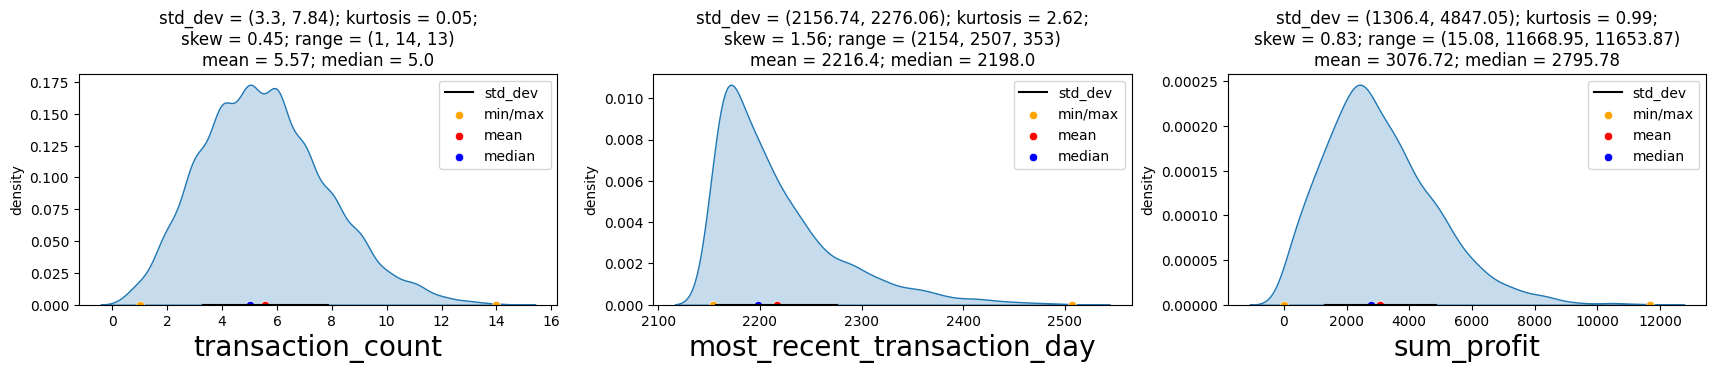

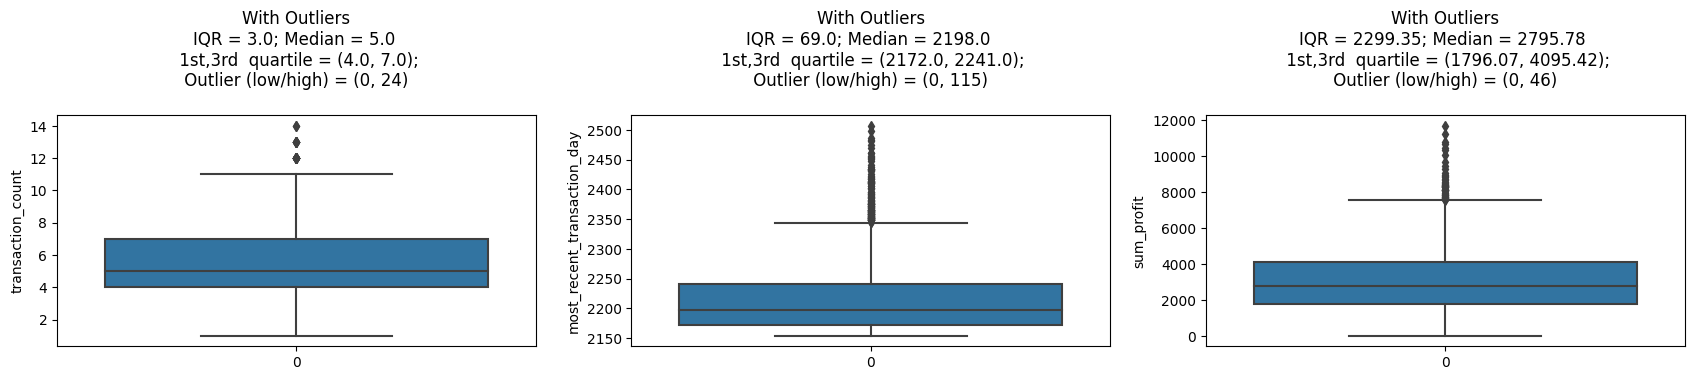

In [12]:
# Import numerical univariate fuction
sys.path.append('/content/drive/MyDrive/Colab Notebooks/kpmg/Scripts')
from EDA import UVA_numeric, UVA_outlier

print(inspect.getsource(UVA_numeric))
print(inspect.getsource(UVA_outlier))

UVA_numeric(RFM_segment, RFM_segment.columns)
UVA_outlier(RFM_segment, RFM_segment.columns)
# There is no extreme outlier and skewness.

[[-1.13135989  0.211285   -1.37332382]
 [ 0.62845333 -0.71076939  0.62283122]
 [ 0.18850003 -0.10724288  1.06708917]
 ...
 [-1.5713132  -0.64371089 -1.42807073]
 [-1.5713132  -0.97900339 -1.56384195]
 [-0.69140658  0.479519    1.18295602]]


,transaction_count,most_recent_transaction_day,sum_profit
mean,1.626754e-16,-2.370412e-15,-1.626754e-16
std,1.000204e+00,1.000204e+00,1.000204e+00


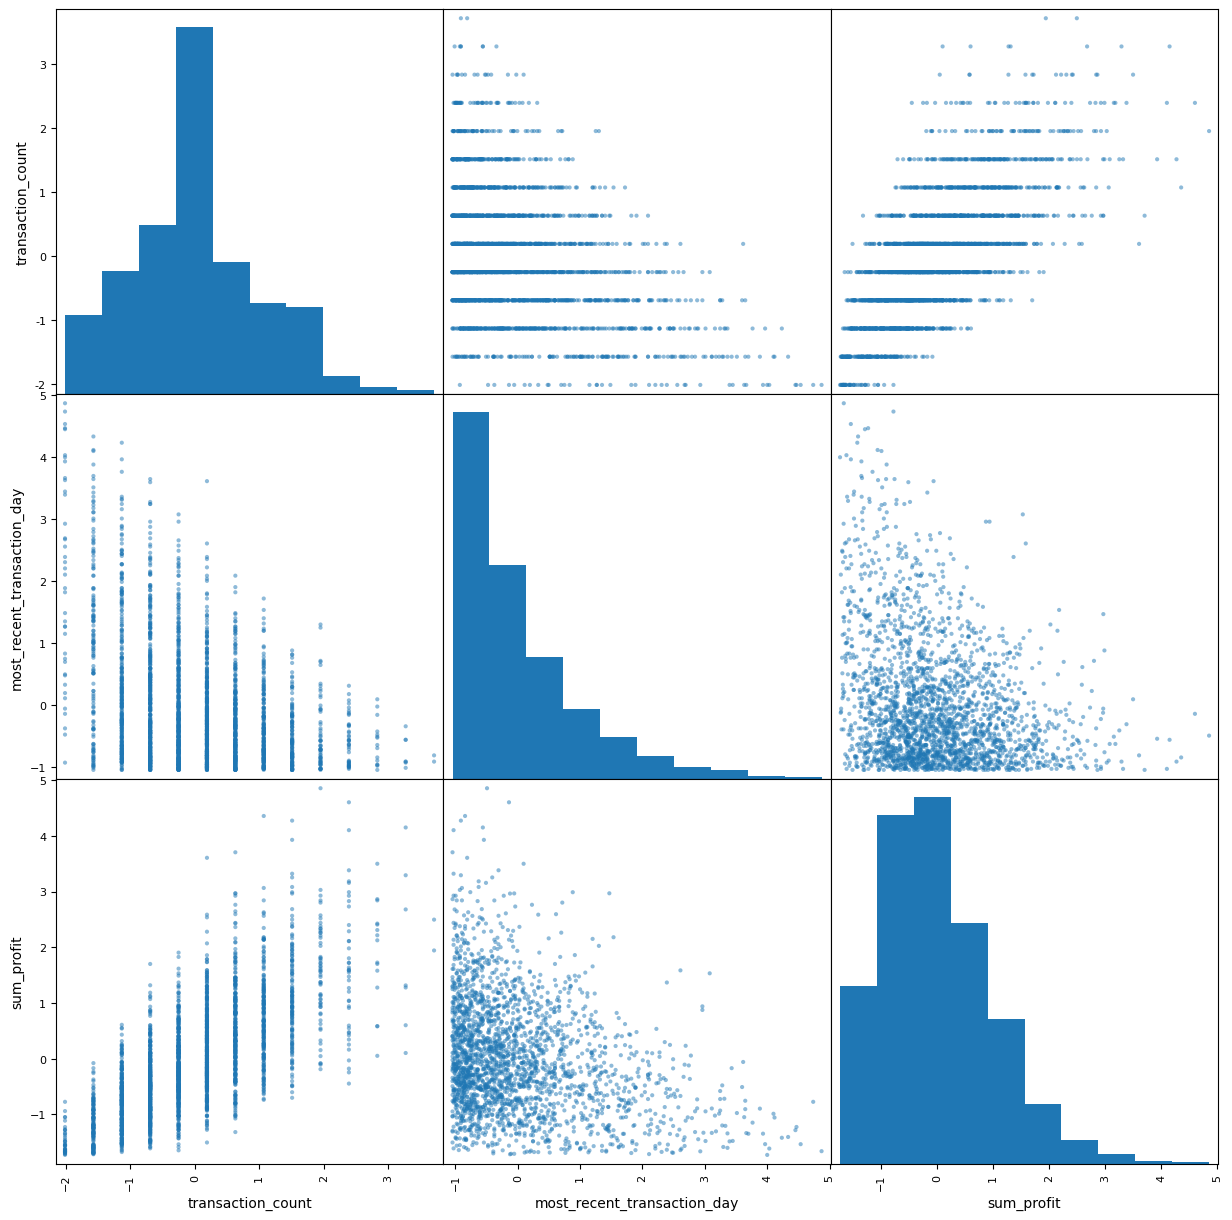

In [31]:
#standardisation and Visualise dataspace
scaler = StandardScaler()
RFM_scaled = scaler.fit_transform(RFM_segment)
print(RFM_scaled)
RFM_scaled = pd.DataFrame(RFM_scaled, index=RFM_segment.index, columns = RFM_segment.columns)
display(RFM_scaled.describe().loc[['mean','std'],:])

scatter_matrix(RFM_scaled[['transaction_count', 'most_recent_transaction_day', 'sum_profit']], figsize=(15, 15))
plt.show()

fig1 = px.scatter_3d(RFM_scaled, x='transaction_count', y='most_recent_transaction_day', z='sum_profit', opacity=0.7)
fig1.update_layout(coloraxis=dict(colorbar=dict(len=0.5)))
fig1.update_traces(mode='markers', marker_line_width=2, marker_size=5)
fig1.show()


## 2.3 RFM Clustering Analysis with K-means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

Silhouette Score for 2 Clusters: 0.3402


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Score for 3 Clusters: 0.3596


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Score for 4 Clusters: 0.2978


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Score for 5 Clusters: 0.2996


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Score for 6 Clusters: 0.2801


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Score for 8 Clusters: 0.2697


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Score for 10 Clusters: 0.2707


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Score for 12 Clusters: 0.2679


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Score for 14 Clusters: 0.2520


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Score for 16 Clusters: 0.2495


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Score for 18 Clusters: 0.2523


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Score for 20 Clusters: 0.2508


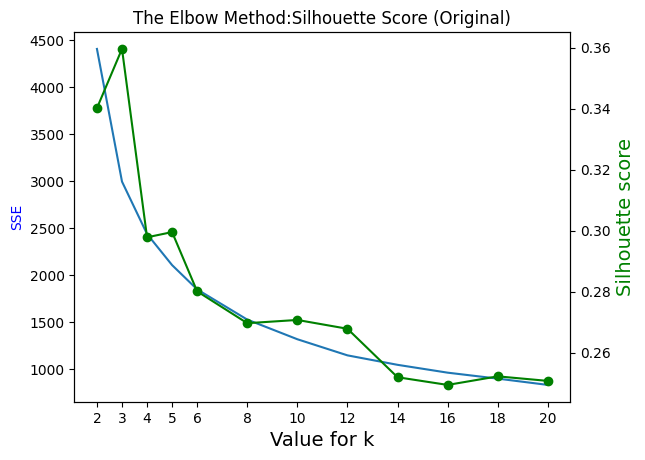

silhouette_score:  0.2978
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2446 entries, 0 to 13624
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   transaction_count            2446 non-null   int64  
 1   most_recent_transaction_day  2446 non-null   int64  
 2   sum_profit                   2446 non-null   float64
 3   label                        2446 non-null   int32  
dtypes: float64(1), int32(1), int64(2)
memory usage: 150.5 KB


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,transaction_count,most_recent_transaction_day,sum_profit,label
0,3,2229,645.99,1
3,7,2174,4179.11,3
10,6,2210,4965.43,3
16,7,2275,3983.97,3
23,8,2165,3960.56,3
...,...,...,...,...
13616,2,2201,1168.94,1
13618,2,2230,1779.58,1
13620,2,2178,549.09,1
13622,2,2158,308.78,1


In [32]:
#3_kmeans
k = [2,3,4,5,6,8,10,12,14,16,18,20]
#k = list(range(1, 11))
#minimise SSE(sum of the squared distance between each member of the cluster and its centroid) when increase K
sse = []
for i in k:
    km = KMeans(n_clusters=i, init = 'k-means++', random_state = 42)
    km.fit(RFM_scaled)
    sse.append(km.inertia_)
#use silhouette coefficient for validate measure quality of the clusters
#evaluating a separation distance between datapoint and its closest cluster (the higher score, the better result (-1,1))
score=[]
for n_cluster in k:
    kmeans = KMeans(n_clusters=n_cluster, init = 'k-means++', random_state = 42)
    kmeans.fit(RFM_scaled)
    silhouette_avg = silhouette_score(RFM_scaled,kmeans.labels_)
    score.append(silhouette_score(RFM_scaled,kmeans.labels_))
    print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))

#identify elbow point to optimal number of clusters at the rate of decrease sharply shifts
fig,ax = plt.subplots()
ax.plot(k, sse)
ax.set_xlabel('Value for k',fontsize=14)
ax.set_ylabel('SSE',color="blue")
ax.set_title('The Elbow Method:Silhouette Score (Original)')
ax.set_xticks(k)
ax1=ax.twinx()
ax1.plot(k, score, 'o-',color='green')
ax1.set_ylabel('Silhouette score',color="green",fontsize=14)
plt.show()

#kmeans k=4
RFM_KMeans = RFM_scaled.copy()
KMeans = KMeans(n_clusters=4, random_state = 42)
KMeans.fit(RFM_KMeans)
score_kmeans = silhouette_score(RFM_KMeans, KMeans.labels_, metric='euclidean')
score_kmeans = "{:.4f}".format(score_kmeans)
print('silhouette_score: ', score_kmeans)

RFM_KMeans['label'] = KMeans.labels_
RFM_segment = RFM_segment.join(RFM_KMeans['label'])
RFM_segment = RFM_segment.dropna()
RFM_segment.info()
display(RFM_segment)

fig2 = px.scatter_3d(RFM_segment, x='transaction_count', y='most_recent_transaction_day', z='sum_profit', opacity=0.7, color='label')
fig2.update_layout(coloraxis=dict(colorbar=dict(len=1)))
fig2.update_traces(mode='markers', marker_line_width=2, marker_size=5)
fig2.show()


In [16]:
# after inspect, we rename cluster into magnitute order
RFM_segment['label'].replace(to_replace=[0, 1, 2, 3],
           value= ['3', '1', '0', '2'],
           inplace=True)
color_map =  {'0':'#EB9C84',
              '1':'#F5FB64',
              '2':'#9D1A9F',
              '3':'#0D0888'}

fig2 = px.scatter_3d(RFM_segment, x='transaction_count', y='most_recent_transaction_day', z='sum_profit', opacity=0.7, color='label',
                     color_discrete_map=color_map)
fig2.update_layout(coloraxis=dict(colorbar=dict(len=1)))
fig2.update_traces(mode='markers', marker_line_width=2, marker_size=5)
fig2.show()

result_feature = pd.melt(RFM_segment, 'label', var_name="features")
print(RFM_segment.groupby('label').mean())
print(RFM_segment.groupby('label').min())
print(RFM_segment.groupby('label').max())

import plotly.figure_factory as ff
#scatter plot
df_seg_cluster = RFM_segment.copy()

class_dict = {'0':'Cluster0',
              '1':'Cluster1',
              '2':'Cluster2',
              '3':'Cluster3'}

df_seg_cluster['label'] = df_seg_cluster['label'].map(class_dict)
fig3 = ff.create_scatterplotmatrix(df_seg_cluster, diag='histogram', index='label',
                                  height=700, width=700,
                                  colormap= dict(
                                      Cluster0 = '#EB9C84',
                                      Cluster1 = '#F5FB64',
                                      Cluster2 = '#9D1A9F',
                                      Cluster3 = '#0D0888'),
                                  colormap_type='cat',
                                  marker=dict(showscale=False, line_width=0.5)
                                  )
fig3.show()

       transaction_count  most_recent_transaction_day   sum_profit
label                                                             
0               3.368715                  2330.879888  1719.632849
1               3.976456                  2197.768278  1827.913011
2               6.465859                  2199.833700  3552.457390
3               8.959786                  2187.142091  5922.992574
       transaction_count  most_recent_transaction_day  sum_profit
label                                                            
0                      1                         2258       15.08
1                      1                         2154       35.74
2                      4                         2154     1172.10
3                      6                         2154     2638.10
       transaction_count  most_recent_transaction_day  sum_profit
label                                                            
0                      8                         2507     5880.33
1   

## 2.4 Hierarchical Clustering on 'Job_title' feature
 we have identified a total of 195 distinct job titles. To categorize these job titles into meaningful groups, we will employ a Hierarchical Clustering approach.
- Vectorization:
- Dendrogram Analysis:
- Applying Hierarchical Clustering:

In [35]:
Customer_segment = RFM.join(RFM_KMeans['label'])
job_num = len(Customer_segment['job_title'].unique())
print('There are {} job titles across all dataset'.format(job_num))

There are 195 job titles across all dataset


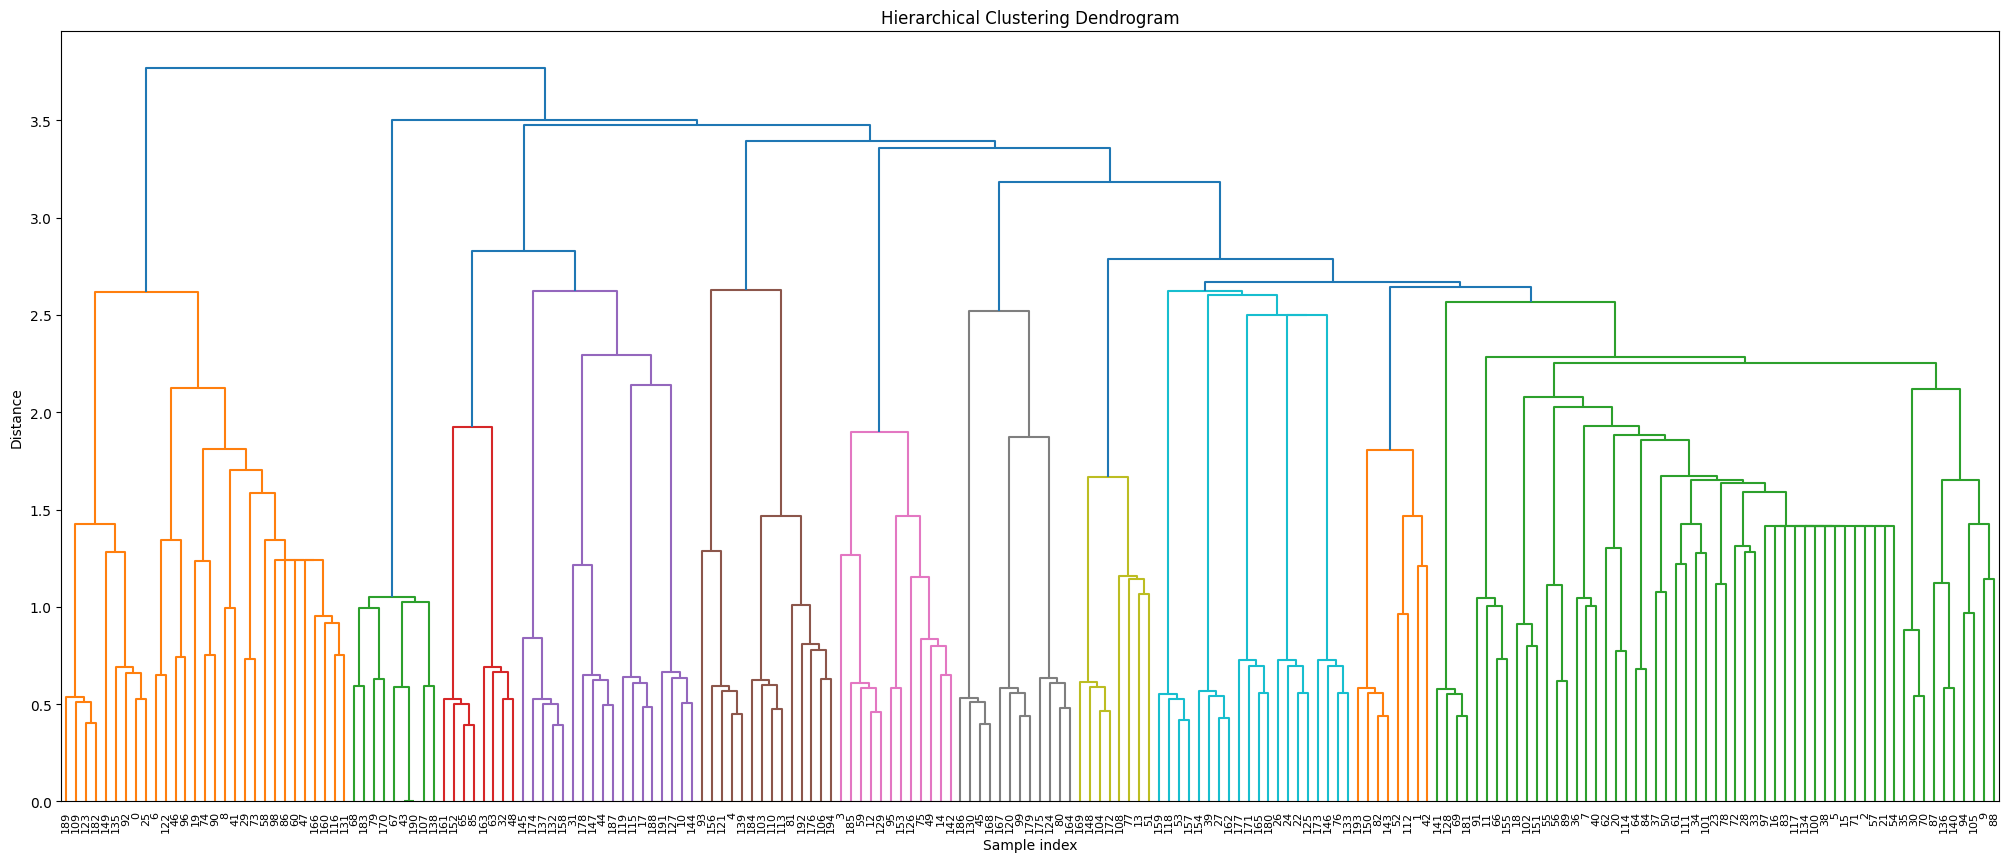

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



,customer_id,transaction_count,most_recent_transaction_day,sum_profit,age,gender,wealth_segment,state,job_title,job_industry_category,owns_car,past_3_years_bike_related_purchases,tenure,property_valuation,label,job_cluster
0,2950,3,2229,645.99,68.0,Male,Mass Customer,VIC,Software Engineer I,Financial Services,True,19.0,10.0,6.0,1,6.0
3,3120,7,2174,4179.11,44.0,Female,Mass Customer,NSW,Clinical Specialist,Health,True,89.0,10.0,5.0,3,3.0
10,402,6,2210,4965.43,46.0,Male,Affluent Customer,NSW,Desktop Support Technician,Retail,False,9.0,22.0,1.0,3,0.0
16,3135,7,2275,3983.97,61.0,Male,Mass Customer,NSW,Staff Scientist,Financial Services,False,83.0,16.0,10.0,3,14.0
23,2339,8,2165,3960.56,64.0,Male,Affluent Customer,NSW,Web Designer II,Property,True,3.0,16.0,10.0,3,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13616,2115,2,2201,1168.94,48.0,Male,Mass Customer,VIC,Food Chemist,Health,True,17.0,17.0,4.0,1,0.0
13618,130,2,2230,1779.58,26.0,Male,Mass Customer,NSW,Chemical Engineer,Manufacturing,False,32.0,1.0,7.0,1,2.0
13620,2789,2,2178,549.09,30.0,Female,Affluent Customer,NSW,Senior Editor,Financial Services,True,66.0,7.0,11.0,1,34.0
13622,3446,2,2158,308.78,56.0,Male,Mass Customer,QLD,Structural Engineer,Manufacturing,False,8.0,14.0,4.0,1,2.0


Cluster 0.0:
Desktop Support Technician
Food Chemist
Pharmacist
Paralegal
Occupational Therapist
Technical Writer
Assistant Media Planner
Legal Assistant
Internal Auditor
Social Worker
Speech Pathologist
Teacher
Physical Therapy Assistant
GIS Technical Architect
Data Coordiator
Actuary
Dental Hygienist
Librarian
Recruiter


Cluster 1.0:
Accountant IV
Accountant III
Accountant II
Cost Accountant
Tax Accountant
Accountant I
Senior Cost Accountant


Cluster 2.0:
Structural Analysis Engineer
Geological Engineer
Nuclear Power Engineer
Civil Engineer
Structural Engineer
Electrical Engineer
Chemical Engineer
Engineer II
Engineer I
Engineer III
Engineer IV


Cluster 3.0:
Clinical Specialist
Community Outreach Specialist
Environmental Tech
Environmental Specialist


Cluster 4.0:
Senior Developer
Web Developer III
Developer II
Web Developer IV
Web Developer I
Developer IV
Web Developer II
Developer III
Developer I


Cluster 5.0:
Quality Engineer
Quality Control Specialist
VP Quality Control
Seni

['/content/drive/MyDrive/Colab Notebooks/kpmg/ClusterModel/hclust.joblib']

In [36]:
# Cluster 'job_title' with Hierarchical Clustering
job_titles = Customer_segment['job_title'].apply(lambda x: x.lower()).unique()

# Vectorize (transforming to numeric) the job titles using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(job_titles)

# Generate the linkage matrix
Z = linkage(tfidf_matrix.toarray(), 'ward')

# Plot the dendrogram ( tree-like diagram that records the sequences of merges or splits)
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

# Choose the number of clusters based on the dendrogram
num_clusters = 41

# Apply Hierarchical clustering
hclust = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')
hclust.fit(tfidf_matrix.toarray())

# Get cluster labels
cluster_labels = hclust.labels_

# Map cluster labels to job titles in the DataFrame
for idx, label in enumerate(job_titles):
    Customer_segment.loc[Customer_segment['job_title'].str.lower() == label, 'job_cluster'] = cluster_labels[idx]

# Display updated DataFrame
display(Customer_segment)

# Group and display job titles by clusters
clustered_job_titles = Customer_segment.groupby('job_cluster')['job_title'].unique()
job_cluster_list = []
for label, job_titles in clustered_job_titles.items():
    print(f"Cluster {label}:")
    for title in job_titles:
        print(title)
        job_cluster_list.append({'job_cluster': label, 'job_title': title})
    print("\n")

# Save Vectorise and hcluster model
dump(vectorizer, '/content/drive/MyDrive/Colab Notebooks/kpmg/ClusterModel/vectorizer.joblib')
dump(hclust, '/content/drive/MyDrive/Colab Notebooks/kpmg/ClusterModel/hclust.joblib')



In [38]:
Customer_segment.to_csv('/content/drive/MyDrive/Colab Notebooks/kpmg/Results/Customer_segment.csv')

# 3.0 Interpretation 4 clusters of the customer segmentation
The following analysis will focus on understanding how certain features relate to customer segmentation and loyalty metrics.

## 3.1 Correlation Analysis
an analysis of feature correlations within a dataset has been conducted to understand customer loyalty. Key points include:

- **RFM features** show significant self-correlation. Specifically, sumprofit is highly correlated with transaction_count and moderately with recency, indicating that more frequent and recent transactions are associated with higher profits.
- **Sumprofit** also correlates with a cluster label, implying that it might be a factor in determining customer segments.
- **Tenure** is moderately positively correlated with age, suggesting that older customers may have been with the company longer.
-**There is a low correlation between other features and both the cluster target and the RFM score**, leading to the assumption that there is no linear relationship for these features.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2446 entries, 2950 to 3168
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   transaction_count                    2446 non-null   int64  
 1   most_recent_transaction_day          2446 non-null   int64  
 2   sum_profit                           2446 non-null   float64
 3   age                                  2446 non-null   float64
 4   gender                               2446 non-null   object 
 5   wealth_segment                       2446 non-null   object 
 6   state                                2446 non-null   object 
 7   job_title                            2446 non-null   object 
 8   job_industry_category                2446 non-null   object 
 9   owns_car                             2446 non-null   bool   
 10  past_3_years_bike_related_purchases  2446 non-null   float64
 11  tenure                     

,transaction_count,most_recent_transaction_day,sum_profit,age,gender,wealth_segment,state,job_title,job_industry_category,owns_car,past_3_years_bike_related_purchases,tenure,property_valuation,label,job_cluster
customer_id,,,,,,,,,,,,,,,
2950,3,2229,645.99,68.0,Male,Mass Customer,VIC,Software Engineer I,Financial Services,True,19.0,10.0,6.0,1,6.0
3120,7,2174,4179.11,44.0,Female,Mass Customer,NSW,Clinical Specialist,Health,True,89.0,10.0,5.0,3,3.0
402,6,2210,4965.43,46.0,Male,Affluent Customer,NSW,Desktop Support Technician,Retail,False,9.0,22.0,1.0,3,0.0
3135,7,2275,3983.97,61.0,Male,Mass Customer,NSW,Staff Scientist,Financial Services,False,83.0,16.0,10.0,3,14.0
2339,8,2165,3960.56,64.0,Male,Affluent Customer,NSW,Web Designer II,Property,True,3.0,16.0,10.0,3,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2115,2,2201,1168.94,48.0,Male,Mass Customer,VIC,Food Chemist,Health,True,17.0,17.0,4.0,1,0.0
130,2,2230,1779.58,26.0,Male,Mass Customer,NSW,Chemical Engineer,Manufacturing,False,32.0,1.0,7.0,1,2.0
2789,2,2178,549.09,30.0,Female,Affluent Customer,NSW,Senior Editor,Financial Services,True,66.0,7.0,11.0,1,34.0


gender {'Female': 0, 'Male': 1}
wealth_segment {'Affluent Customer': 0, 'High Net Worth': 1, 'Mass Customer': 2}
state {'NSW': 0, 'QLD': 1, 'VIC': 2}
job_title {'Account Coordinator': 0, 'Account Executive': 1, 'Account Representative I': 2, 'Account Representative II': 3, 'Account Representative III': 4, 'Account Representative IV': 5, 'Accountant I': 6, 'Accountant II': 7, 'Accountant III': 8, 'Accountant IV': 9, 'Accounting Assistant I': 10, 'Accounting Assistant II': 11, 'Accounting Assistant III': 12, 'Accounting Assistant IV': 13, 'Actuary': 14, 'Administrative Assistant I': 15, 'Administrative Assistant II': 16, 'Administrative Assistant III': 17, 'Administrative Assistant IV': 18, 'Administrative Officer': 19, 'Analog Circuit Design manager': 20, 'Analyst Programmer': 21, 'Assistant Manager': 22, 'Assistant Media Planner': 23, 'Assistant Professor': 24, 'Associate Professor': 25, 'Automation Specialist I': 26, 'Automation Specialist II': 27, 'Automation Specialist III': 28, 'Au

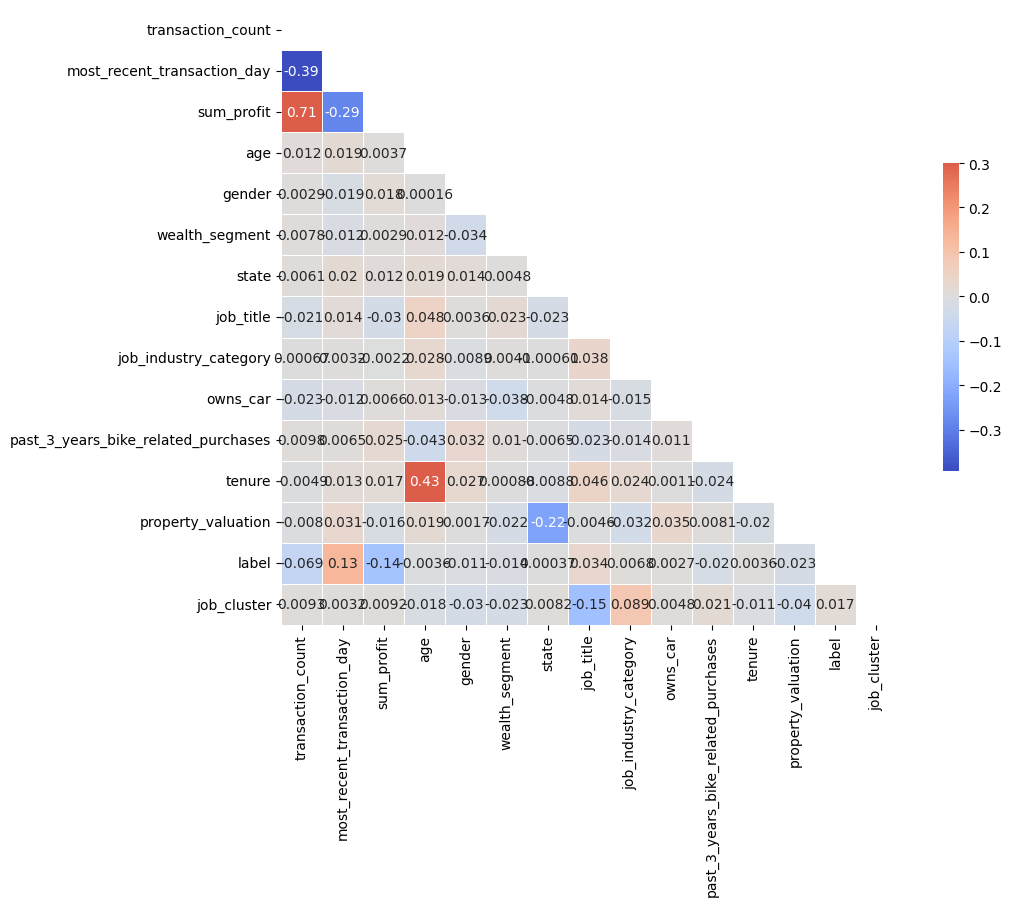

In [2]:
Customer_segment = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kpmg/Results/Customer_segment.csv', index_col=1)
Customer_segment = Customer_segment.drop('Unnamed: 0', axis=1)
Customer_segment.info()
display(Customer_segment)

#feature encoding for visualising
Customer_segment_numeric = Customer_segment.copy()
label_encoders = {}
for cols in Customer_segment_numeric.select_dtypes(include=['object','bool']):
    label = LabelEncoder()
    Customer_segment_numeric[cols] = label.fit_transform(Customer_segment_numeric[cols])
    # Store the LabelEncoder for this column
    label_encoders[cols] = label
    print(cols, dict(zip(label.classes_, label.transform(label.classes_))))

# Generate a correlation matrix
corr_matrix = Customer_segment_numeric.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, cmap="coolwarm", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

In [7]:
print('Data Correlation:')
plt.figure(figsize=(6,6))
sns.pairplot(Customer_segment_numeric, hue='label', palette='Dark2', corner=True, kind='reg')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

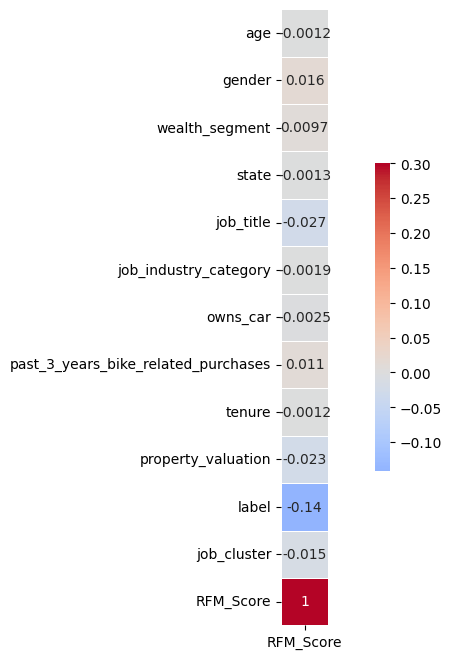

In [25]:
# We also combine each RFM features to one score and observe the relationship
scaler = MinMaxScaler()
Customer_segment_numeric[['transaction_count', 'most_recent_transaction_day', 'sum_profit']] = scaler.fit_transform(Customer_segment_numeric[['transaction_count', 'most_recent_transaction_day', 'sum_profit']])
Customer_segment_numeric['most_recent_transaction_day'] = 1 - Customer_segment_numeric['most_recent_transaction_day']
Customer_segment_numeric['RFM_Score'] = Customer_segment_numeric['most_recent_transaction_day'] + Customer_segment_numeric['transaction_count'] + Customer_segment_numeric['sum_profit']
Customer_segment_numeric = Customer_segment_numeric.drop(['transaction_count', 'most_recent_transaction_day', 'sum_profit'], axis=1)

# Generate a correlation matrix
corr_matrix = Customer_segment_numeric.corr()
target_correlation = corr_matrix[['RFM_Score']]
plt.figure(figsize=(12, 8))
sns.heatmap(target_correlation, cmap="coolwarm", vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()


# New section

## 3.2 Statistical Analysis (Bivariate Analysis and Hypothesis Test)

  We perform statistical analyses and hypothesis testing to evaluate the associations between the target RFM cluster and other independent variables.

- One-Way ANOVA (Analysis of Variance): This test is used to assess whether there are any statistically significant differences between the means of independent groups based on a continuous dependent variable.

- Chi-Squared Test: This test helps to establish if a substantial relationship exists between two categorical variables.



In [2]:
# Import Bivariate analysis fuction from the scripts folder
sys.path.append('/content/drive/MyDrive/Colab Notebooks/kpmg/Scripts')

from EDA import BVA_categorical_plot, one_way_ANOVA
print(inspect.getsource(BVA_categorical_plot))
print(inspect.getsource(one_way_ANOVA))

def BVA_categorical_plot(data, tar, cat):
    '''
    performing a chi-squared test to determine if there is a significant association between two categorical variables.
    take data and two categorical variables,
    calculates the chi2 significance between the two variables
    and prints the result with countplot & CrossTab
    '''
    #isolating the variables
    data = data[[cat,tar]][:]

    #forming a crosstab
    table = pd.crosstab(data[tar],data[cat])

    #performing chi2 test
    from scipy.stats import chi2_contingency
    chi, p, dof, expected = chi2_contingency(table)

    #checking whether results are significant
    if p<0.05:
        sig = True
    else:
        sig = False

    #setting up the matplotlib figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    desired_order = sorted(data[tar].unique(), reverse=False)

    #plotting grouped plot
    sns.countplot(x=cat, hue=tar, data=data, ax=axes[0], hue_order=desired_order)
    axes[0].set_title(f"p-value = {

In [3]:
col_RFM = ['transaction_count', 'most_recent_transaction_day','sum_profit']
col_customer_con = ['age', 'past_3_years_bike_related_purchases', 'tenure', 'property_valuation']
col_customer_cata = ['gender', 'wealth_segment', 'state',
       'job_industry_category', 'owns_car','job_cluster']

- One-Way ANOVA

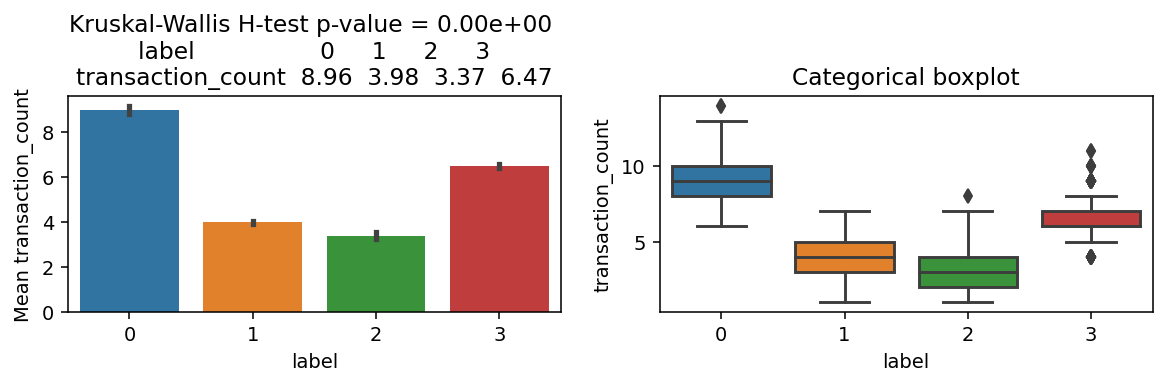

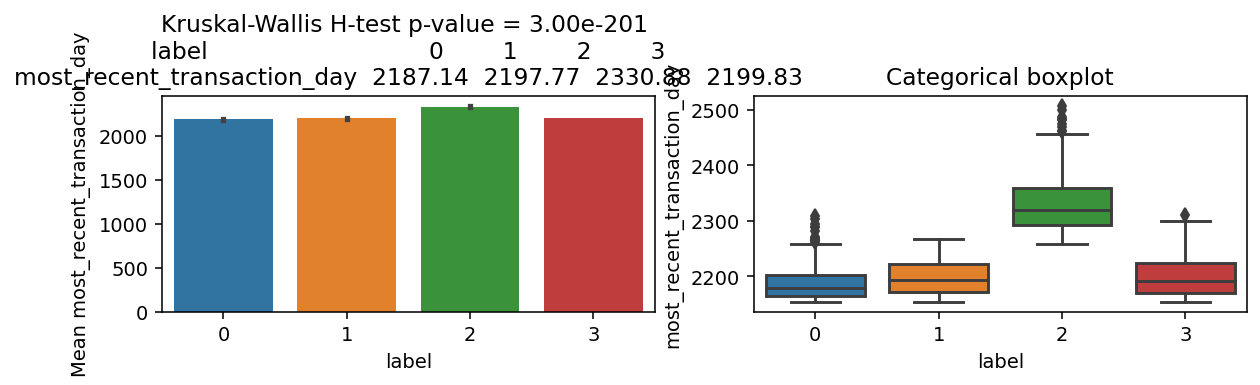

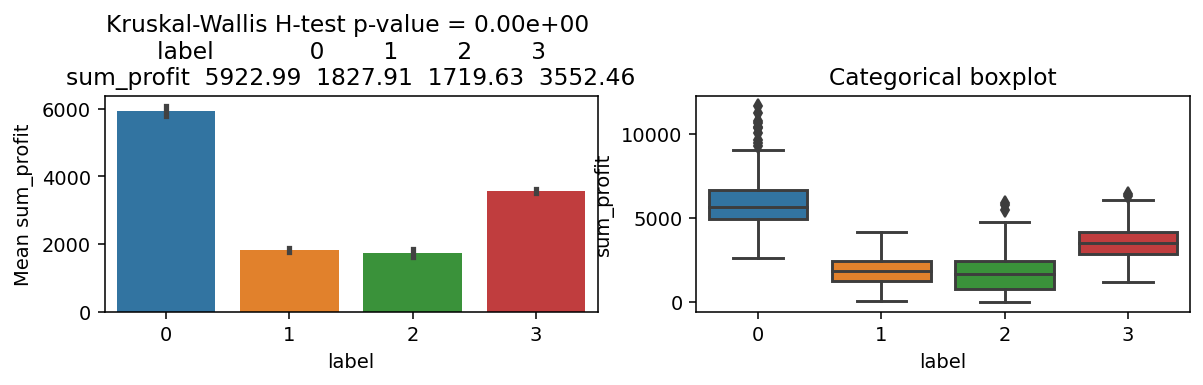

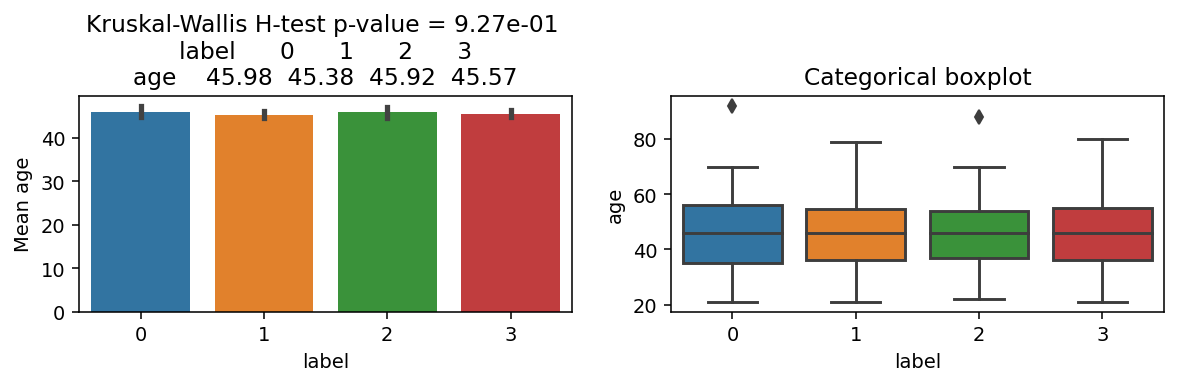

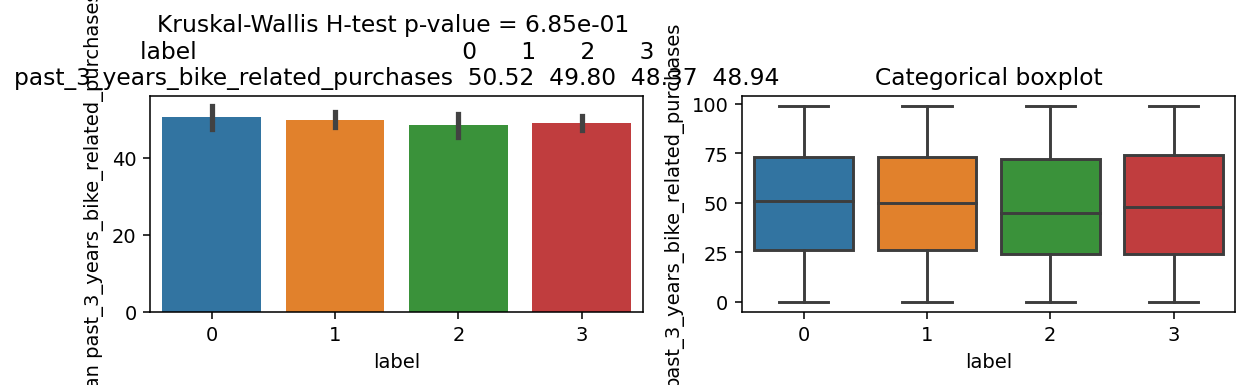

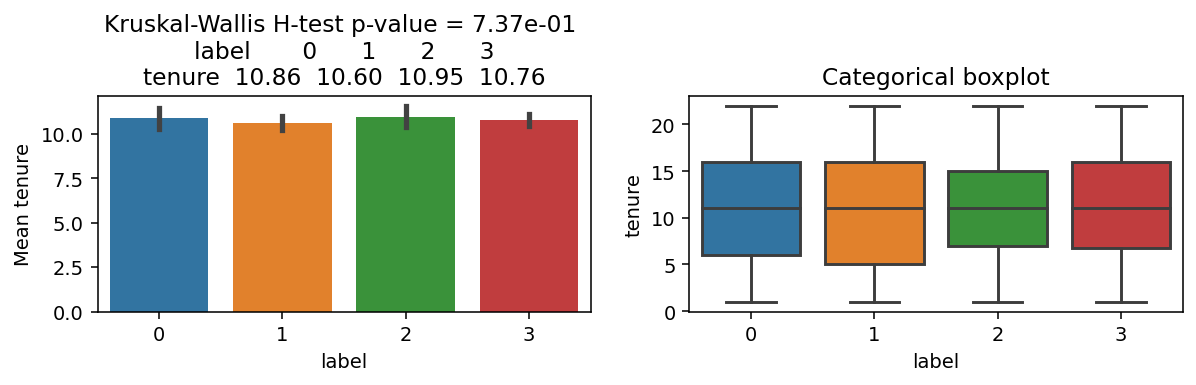

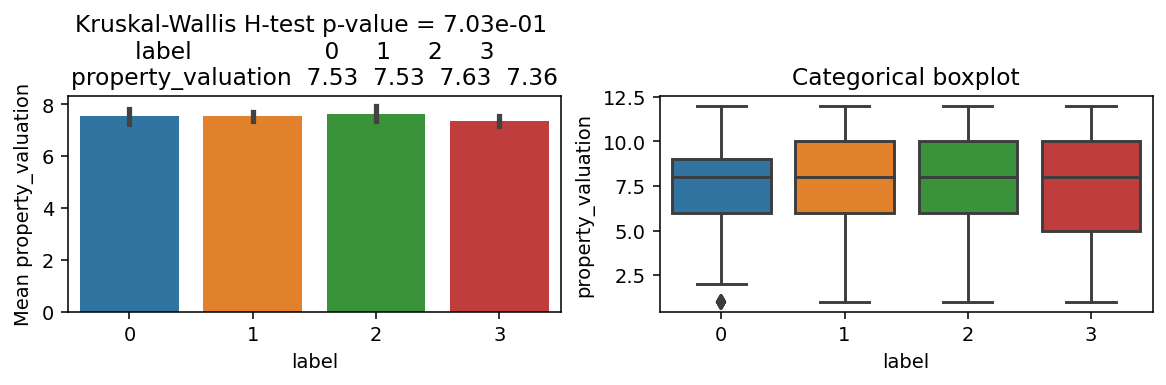

In [4]:
Customer_segment = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kpmg/Results/Customer_segment.csv', index_col=1)
Customer_segment = Customer_segment.drop('Unnamed: 0', axis=1)
for col in col_RFM:
  one_way_ANOVA(Customer_segment, col, 'label')
for col in col_customer_con:
  one_way_ANOVA(Customer_segment, col, 'label')

- Chi-Squared Test

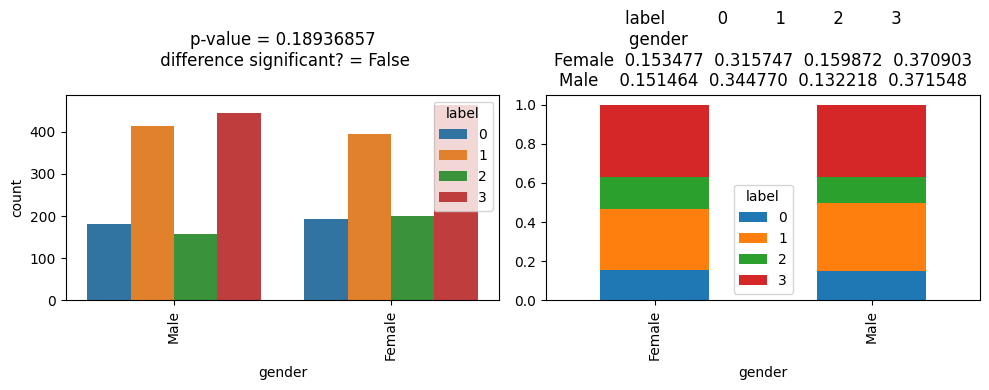

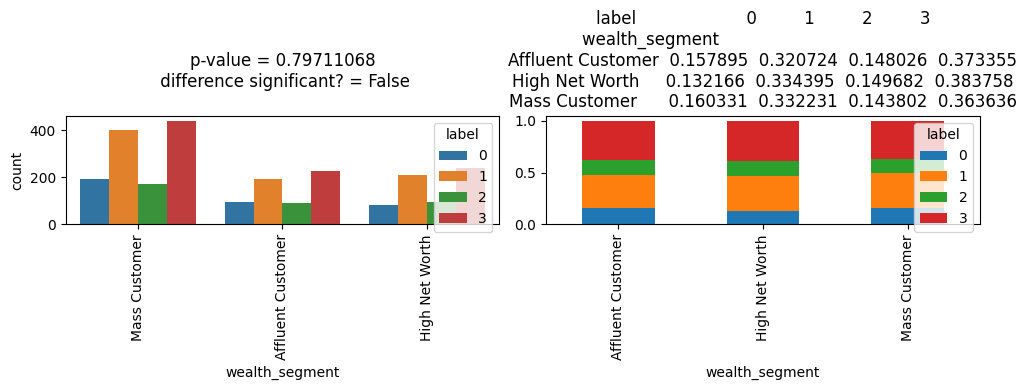

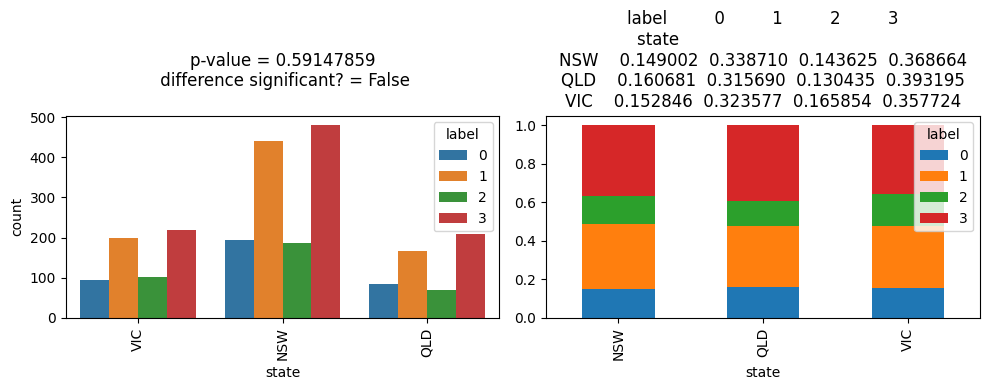

/content/drive/MyDrive/Colab Notebooks/kpmg/Scripts/EDA.py:119: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


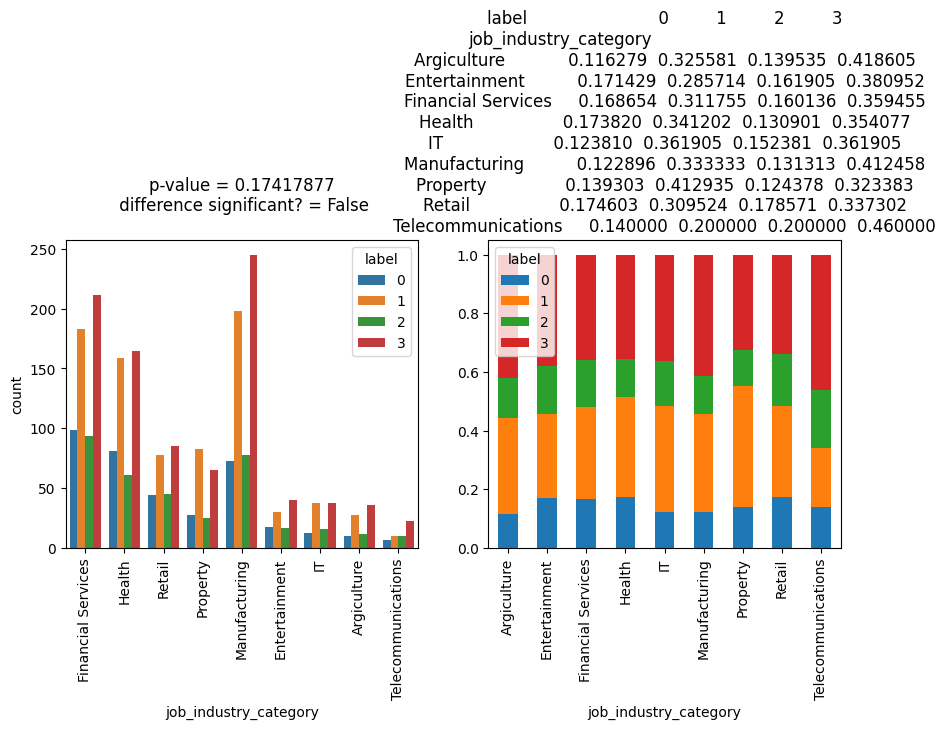

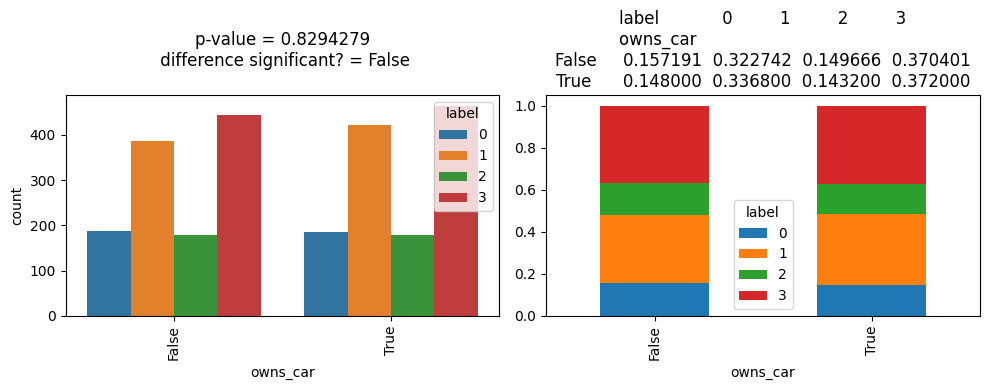

/content/drive/MyDrive/Colab Notebooks/kpmg/Scripts/EDA.py:119: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


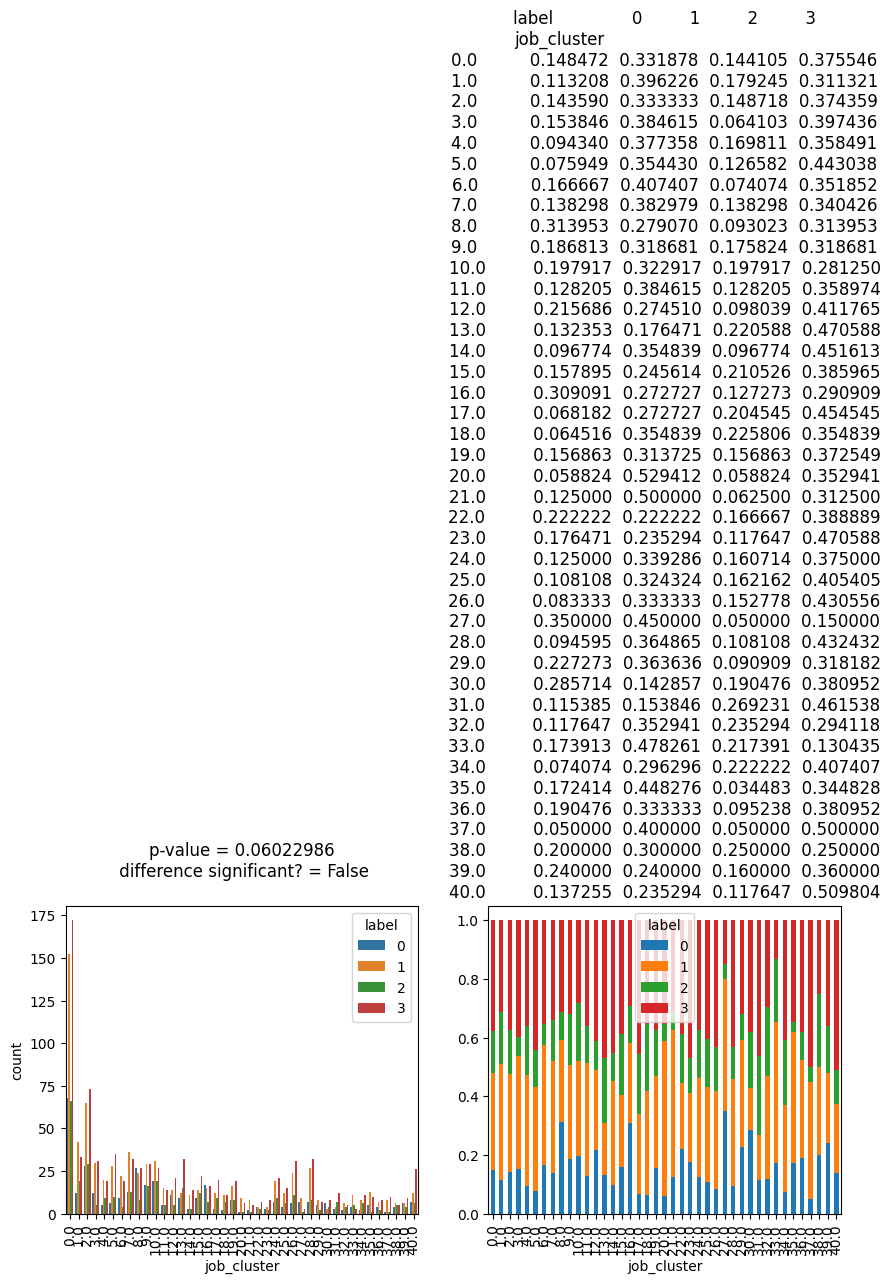

In [5]:
for col in col_customer_cata:
  BVA_categorical_plot(Customer_segment, 'label', col)

- The findings indicate that statistical significance is observed only between clusters within the RFM feature itself, and not with other features. This could potentially be Intrinsic RFM Relationships that inherently related as they all directly describe customer transaction behavior.

- We can conclue a Non-Linear Relationships the ANOVA or Chi-Squared tests cannot detect the significance.


- Nonetheless, visual analysis reveals noticeable variations in the distribution for certain features which can be the result of an influence of high variance within the groups. Noticable features includes 'age', 'tenure', 'property_valuation', as well as the most significance in 'job_industry_category', and 'job_title_cluster.

- Therefore, more sophisticated analytical techniques, such as machine learning algorithms will be applied on the next stage to deal with complex patterns and relationships in this dataset.